In [1]:
import sys
sys.path.insert(0, '../')
from lib.io_functions import load_npy, save_proccesed_variables
from lib.fit_functions import fit_wvfs,scfunc, gauss
from lib.sim_functions import rand_scint_times, larsoft_template
from lib.wvf_functions import find_baseline_cuts, find_amp_decrease
from lib.dec_functions import deconvolve

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit


[]

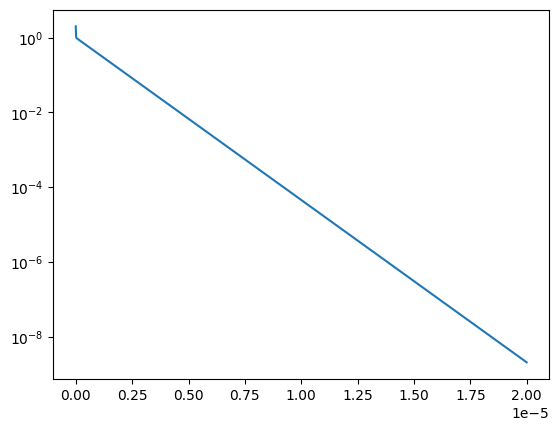

In [4]:
time = np.arange(0, 20e-6, 4e-9)
func = np.exp(-time/6e-9) + np.exp(-time/1e-6)
plt.plot(time,func)
plt.semilogy()
plt.plot()

In [2]:
# Setup wvf and plot parameters.
plt.rcParams.update({'font.size': 15})

# Load data for wvf template (LARSOFT)
raw_SER = open("../larsoft/PDS/SPE_maritza.txt")
SER = np.asarray(raw_SER.readlines()).astype(float)

# raw_SER = open("../larsoft/PDS/fbk_DAPHNE_Dec22.txt")
# SER = np.asarray(raw_SER.readlines()).astype(float)

# Load data for wvf template (LAB)
# lab_run = load_npy([2],[6],"Average_","../data/ave/")
# SER = lab_run[2][6]["SPEAvWvf"]

# Generate dict with required structure
my_run = dict()
my_run["NRun"] = [0]
my_run["NChannel"] = [0]
my_run[0] = dict()
my_run[0][0] = dict()
my_run[0][0]["Sampling"] = 16e-9
my_run[0][0]["TimeWindow"] = 800 # Additional baseline after signal [ticks]
my_run[0][0]["PreTrigger"] = 200 # Additional baseline before signal [ticks]

# Generate empty array to import data
SER = np.append(np.asarray(SER),np.zeros(my_run[0][0]["TimeWindow"]))
SER = np.append(np.zeros(my_run[0][0]["PreTrigger"]),np.asarray(SER))
my_run[0][0]["ADC"] = [np.array(SER)]


In [3]:
opt = {
    "SHOW": False,
    "NOISE_AMP": 0.5,
    "FIX_EXP":True,
    "WIENER_BUFFER": 100,
    "FILTER": "Gauss",
    "PRO_RODRIGO": False,
    "CONVERT_ADC": True,
    "TERMINAL_OUTPUT": False
    }
    
my_run[0][0]["FitParam"] = fit_wvfs(my_run,"SC",1e-4,fit_range=[0,len(my_run[0][0]["ADC"])-my_run[0][0]["TimeWindow"]],out_key="SPE",OPT=opt)
i_base_idx,f_base_idx = find_baseline_cuts(my_run[0][0]["FitSCSPE"][0])
i_thrld_idx,f_thrld_idx = find_amp_decrease(my_run[0][0]["FitSCSPE"][0],1e-4)

my_run[0][0]["PreSignal"] = len(my_run[0][0]["FitSCSPE"][0][:i_thrld_idx])
my_run[0][0]["PostSignal"] = len(my_run[0][0]["FitSCSPE"][0][i_thrld_idx:])
# post = len(my_run[0][0]["FitSCSPE"][0][i_thrld_idx:])

my_run[0][0]["FitSPEChargeADC"] = np.trapz(my_run[0][0]["FitSCSPE"][0][:f_base_idx],my_run[0][0]["Sampling"]*np.arange(f_base_idx))
my_run[0][0]["FitSPEUnderChargeADC"] = np.trapz(my_run[0][0]["FitSCSPE"][0][f_base_idx:],my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitSCSPE"][0][f_base_idx:])))
my_run[0][0]["SPEChargeADC"] = np.trapz(my_run[0][0]["ADC"][0][:f_base_idx],my_run[0][0]["Sampling"]*np.arange(f_base_idx))
my_run[0][0]["SPEUnderChargeADC"] = np.trapz(my_run[0][0]["ADC"][0][f_base_idx:],my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0][f_base_idx:])))

print("Total int of signal (should be close to 0 for bipolar wvfs.): ", my_run[0][0]["Sampling"]*np.sum(my_run[0][0]["ADC"][0]))
print(100*my_run[0][0]["SPEChargeADC"]/(-my_run[0][0]["SPEUnderChargeADC"]))

Fitting wvf  0


Total int of signal (should be close to 0 for bipolar wvfs.):  -1.5135606569599982e-08
92.4366077407921


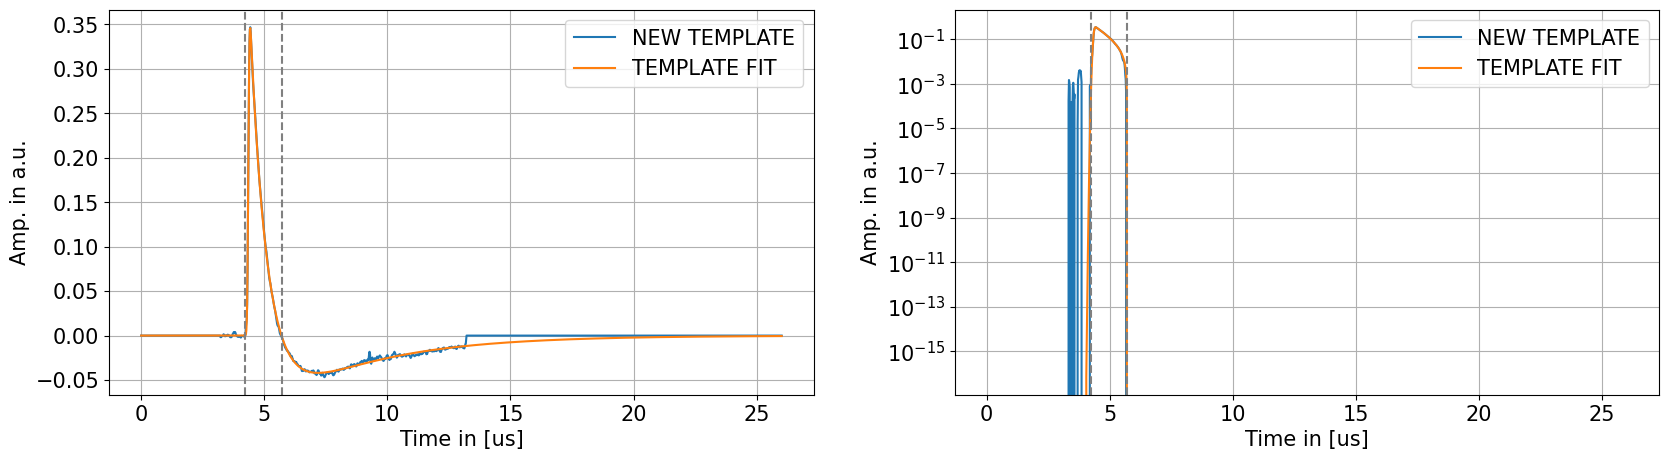

In [4]:
fig, ax = plt.subplots(1 ,2, figsize = (20,5))
time_array = 1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["FitSCSPE"][0]))
peaktime = 1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["ADC"]))
# print(time_array.size)
for i in range(len(ax)):
    ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0],label="NEW TEMPLATE")
    # ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["ADC"][0])),my_run[0][0]["ADC"][0]/np.max(my_run[0][0]["ADC"][0]),label="NEW TEMPLATE")
    ax[i].plot(time_array,my_run[0][0]["FitSCSPE"][0],label="TEMPLATE FIT")
    # ax[i].plot(time_array,larsoft_template(time_array,peaktime,151.5,0.066,0.013,0.2)/np.max(larsoft_template(time_array,peaktime,151.5,0.066,0.013,0.2)),label="OLD TEMPLATE",c="red")
    ax[i].axvline(1e6*my_run[0][0]["Sampling"]*i_thrld_idx,ls="--",c="grey")
    ax[i].axvline(1e6*my_run[0][0]["Sampling"]*f_thrld_idx,ls="--",c="grey")
    # ax[i].axvline(1e6*my_run[0][0]["Sampling"]*np.argmax(my_run[0][0]["FitSCSPE"][0]),c="black",label="RISE TIME: %.2f"%(1e6*my_run[0][0]["Sampling"]*(np.argmax(my_run[0][0]["FitSCSPE"][0])-i_thrld_idx)))
    ax[i].set_ylabel("Amp. in a.u.")
    ax[i].set_xlabel("Time in [us]")
    ax[i].legend(fontsize=15)
    ax[i].grid(True)
    # ax[i].set_xlim([3.5,8])
ax[1].semilogy()
plt.show()

In [5]:
i_SPE_Fit_thrld_idx,f_SPE_Fit_thrld_idx = find_amp_decrease(my_run[0][0]["FitSCSPE"][0],1e-4)
my_run[0][0]["SER"] = []
my_run[0][0]["SER"].append(np.roll(my_run[0][0]["FitSCSPE"][0],-i_SPE_Fit_thrld_idx))

key = ["ADC","SER","DecADC"]
opt["CONVERT_ADC"] = False
opt["FILTER"] = "GAUSS"
# opt["SHOW_F_SIGNAL"] = True
# opt["SHOW_GAUSS_SIGNAL"] = False
opt["SHOW_F_GAUSS"] = True
# opt["SHOW_F_DET_RESPONSE"] = True
opt["SHOW_F_WIENER"] = True
# opt["SHOW_F_DEC"] = True
opt["SHOW"] = False
deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution

opt["FILTER"] = "WIENER"
deconvolve(my_run,my_run,my_run,key,opt) # Sanity check deconvolution


Generated wvfs with key GaussDecADC
Generated wvfs with key WienerDecADC


In [6]:
# Compute SPE integrals
dec_label = ["Gauss","Wiener"]
int_range = 20
for label in dec_label:
    peak_max  = np.argmax(my_run[0][0][label+"DecADC"][0])
    my_run[0][0][label+"Peak"]     = peak_max
    my_run[0][0][label+"NoiseSTD"] = np.std(my_run[0][0][label+"DecADC"][0][2000:])
    my_run[0][0][label+"SPEInt1"]  = np.sum(my_run[0][0][label+"DecADC"][0][my_run[0][0][label+"Peak"]-int_range*1:my_run[0][0][label+"Peak"]+int_range*1])
    my_run[0][0][label+"SPEInt2"]  = np.sum(my_run[0][0][label+"DecADC"][0][my_run[0][0][label+"Peak"]-int_range*2:my_run[0][0][label+"Peak"]+int_range*2])
    my_run[0][0][label+"SPEInt3"]  = np.sum(my_run[0][0][label+"DecADC"][0][my_run[0][0][label+"Peak"]-int_range*3:my_run[0][0][label+"Peak"]+int_range*3])
    # print(my_run[0][0][label+"SPEInt1"])
    # print(my_run[0][0][label+"SPEInt2"])
    # print(my_run[0][0][label+"SPEInt3"])
    # print(my_run[0][0][label+"NoiseSTD"])

/home/smanthey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/smanthey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/smanthey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


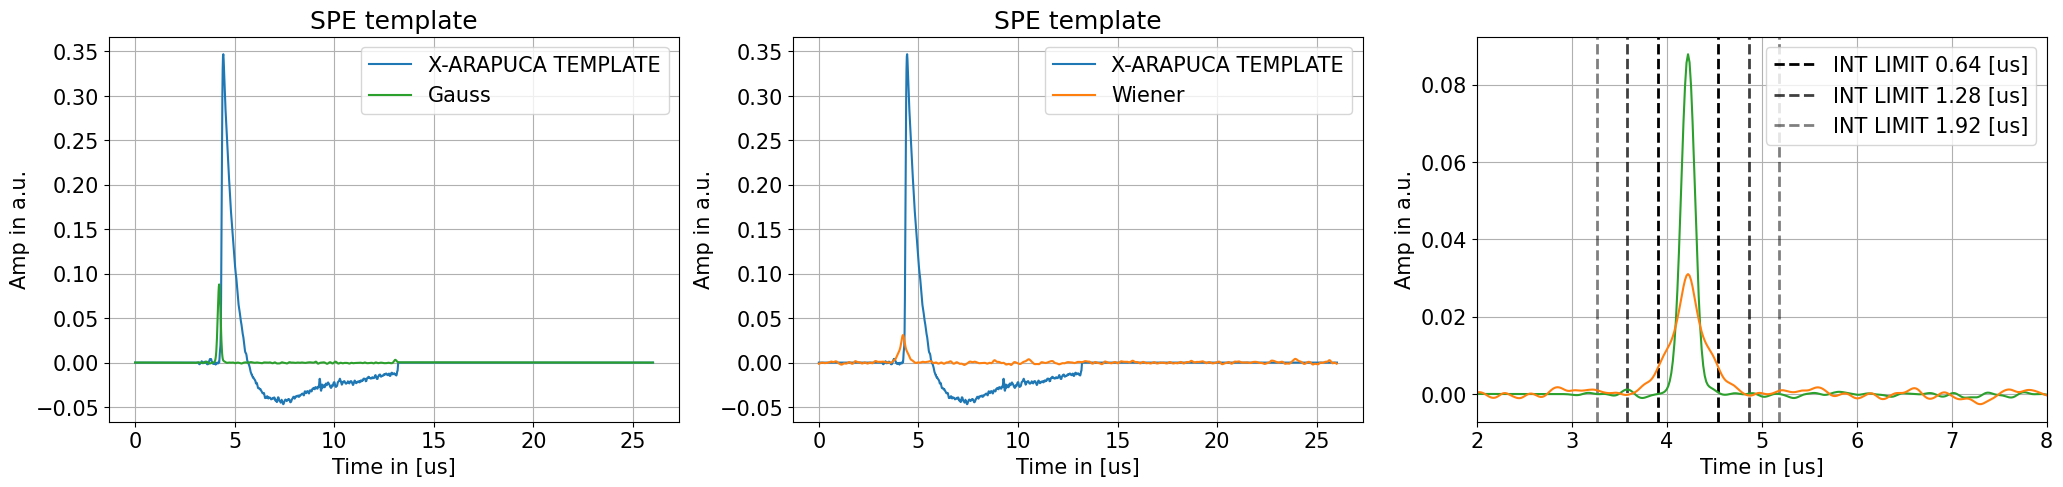

In [7]:
color = ["tab:green","tab:orange"]
fig,ax = plt.subplots(1,3,figsize=(25,5))
for i in range(len(ax)):            
    if i == 0 or i == 1: 
        ax[i].set_title("SPE template")
        ax[i].set_xlabel("Time in [us]")
        ax[i].set_ylabel("Amp in a.u.")
        ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][key[0]][0])),my_run[0][0]["ADC"][0],label="X-ARAPUCA TEMPLATE")
        ax[i].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0][dec_label[i]+key[2]][0])),my_run[0][0][dec_label[i]+key[2]][0],c=color[i],label=dec_label[i])
    else:
        for ii in range(3):
            ax[i].axvline(1e6*my_run[0][0]["Sampling"]*(my_run[0][0][label+"Peak"]-int_range*(ii+1)),ls="--",lw=2,c="k",alpha=1-0.25*(ii),label="INT LIMIT %.2f [us]"%((1+ii)*2*int_range*1e6*my_run[0][0]["Sampling"]))
            ax[i].axvline(1e6*my_run[0][0]["Sampling"]*(my_run[0][0][label+"Peak"]+int_range*(ii+1)),ls="--",lw=2,c="k",alpha=1-0.25*(ii))

    ax[i].grid(True)
    ax[i].legend()

ax[2].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Gauss"+key[2]][0])),my_run[0][0]["Gauss"+key[2]][0],c="tab:green")
ax[2].plot(1e6*my_run[0][0]["Sampling"]*np.arange(len(my_run[0][0]["Wiener"+key[2]][0])),my_run[0][0]["Wiener"+key[2]][0],c="tab:orange")
ax[2].set_xlabel("Time in [us]")
ax[2].set_ylabel("Amp in a.u.")
ax[2].set_xlim([2,8])
plt.show()

In [8]:
save_proccesed_variables(my_run, "Analysis_", "../data/ana/")

Saved data in: ../data/ana/Analysis_run00_ch0.npy
